In [6]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [7]:
df = pd.read_csv('updated_dataframe.csv')
df.head()

,id,title,abstract,keywords,journal,keyword_count,embedding,similar_papers,high_similarity_count,keyword_similarity_count,jaccard_similarity_count,connection_range
0,cs_1,Fighting malicious code: an eternal struggle,Despite many years of research and significant...,"Security and privacy, Intrusion/anomaly detect...",ACM Conference on Computer and Communications ...,4,[-7.15448707e-02 8.84855911e-03 -2.46604253e-...,"[('cs_17', 0.54332185), ('cs_1384', 0.5124493)...",12,84,58,10-15
1,cs_2,Letting the puss in boots sweat: detecting fak...,The only available IEEE 802.11 network identif...,"Networks, Network services, Network types, Pub...",ACM Conference on Computer and Communications ...,6,[-1.00172892e-01 2.39987839e-02 1.78415999e-...,"[('cs_24', 0.52022445), ('cs_64', 0.55415004),...",34,380,130,30-50
2,cs_3,Scanner hunter: understanding HTTP scanning tr...,This paper focuses on detecting and studying H...,Applied computing,ACM Conference on Computer and Communications ...,1,[-6.70441166e-02 3.52663756e-03 -4.61701825e-...,"[('cs_4', 0.56352115), ('cs_11', 0.59189296), ...",30,0,95,20-30
3,cs_4,Detection of stealthy malware activities with ...,Studies show that a significant portion of net...,"Security and privacy, Network security",ACM Conference on Computer and Communications ...,2,[-9.63144079e-02 2.17957748e-03 2.55297739e-...,"[('cs_3', 0.56352115), ('cs_17', 0.61029315), ...",54,25,40,30-50
4,cs_5,Re3: relay reliability reputation for anonymit...,"To conceal user identities, Tor, a popular ano...","Security and privacy, Network security",ACM Conference on Computer and Communications ...,2,[-1.16817787e-01 -1.11325048e-02 -4.36492525e-...,"[('cs_6', 0.5136872), ('cs_41', 0.5262448), ('...",56,25,40,30-50


In [15]:
class JournalGCN(nn.Module):
    def __init__(self, num_journals, num_papers, embedding_dim=384):
        super(JournalGCN, self).__init__()
        
        # Learnable journal embeddings
        self.journal_embeddings = nn.Parameter(torch.randn(num_journals, embedding_dim) * 0.01)
        
        # Fixed paper embeddings (not parameters)
        self.register_buffer('paper_embeddings', torch.zeros(num_papers, embedding_dim))
        
        # GCN layers
        self.conv1 = GCNConv(embedding_dim, embedding_dim)
        self.conv2 = GCNConv(embedding_dim, embedding_dim)
        
        # Batch normalization and dropout
        self.batch_norm = nn.BatchNorm1d(embedding_dim)
        self.dropout = nn.Dropout(0.2)

    def set_paper_embeddings(self, embeddings):
        """Set the fixed paper embeddings"""
        self.paper_embeddings.copy_(embeddings)

    def forward(self, edge_index):
        # Combine journal and paper embeddings
        x = torch.cat([self.journal_embeddings, self.paper_embeddings], dim=0)
        
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        
        # L2 normalize embeddings
        x = F.normalize(x, p=2, dim=1)
        
        # Split back into journal and paper embeddings
        journal_emb = x[:len(self.journal_embeddings)]
        paper_emb = x[len(self.journal_embeddings):]
        
        return journal_emb, paper_emb

In [18]:
def predict_journals(model_path, embeddings_path, test_data_df, top_k=5):
    """
    Load saved model and make predictions for new test data
    
    Args:
        model_path: Path to saved model file
        embeddings_path: Path to saved embeddings file
        test_data_df: DataFrame containing test papers with 'abstract' and 'embedding' columns
        top_k: Number of top predictions to return
    """
    # Load model and embeddings
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Load model to CPU first, then move to appropriate device
    model_info = torch.load(model_path, map_location='cpu', weights_only=True)
    embeddings_df = pd.read_csv(embeddings_path)
    
    # Initialize model with the current number of test papers
    num_journals = model_info['num_journals']
    embedding_dim = model_info['embedding_dim']
    num_test_papers = len(test_data_df)
    
    model = JournalGCN(
        num_journals=num_journals,
        num_papers=num_test_papers,  # Use current number of test papers
        embedding_dim=embedding_dim
    ).to(device)
    
    # Load only the journal embeddings and other parameters, excluding paper_embeddings
    state_dict = model_info['model_state_dict']
    
    # Remove paper_embeddings from state_dict since it will be different size
    if 'paper_embeddings' in state_dict:
        del state_dict['paper_embeddings']
    
    # Load the remaining weights
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    
    # Convert test paper embeddings to tensor
    # Parse string representation of embeddings to numpy arrays
    embeddings_list = []
    for emb_str in test_data_df['embedding']:
        # Convert string representation to numpy array
        emb_list = [float(x) for x in emb_str.strip('[]').split()]
        embeddings_list.append(np.array(emb_list))
    
    test_embeddings = np.stack(embeddings_list)
    test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float).to(device)
    
    # Set paper embeddings in model
    model.paper_embeddings = nn.Parameter(test_embeddings_tensor)
    
    # Create edge index for inference
    num_total_nodes = num_journals + num_test_papers
    adj_matrix = np.zeros((num_total_nodes, num_total_nodes))
    
    # Set journal-journal connections to 1 (fully connected)
    adj_matrix[:num_journals, :num_journals] = 1
    np.fill_diagonal(adj_matrix, 0)  # Remove self-loops
    
    # Create edge index
    edge_index = torch.tensor(np.array(np.where(adj_matrix > 0)), dtype=torch.long).to(device)
    
    # Get predictions
    with torch.no_grad():
        journal_embeddings, paper_embeddings = model(edge_index)
        similarities = torch.mm(paper_embeddings, journal_embeddings.t())
        
        # Get top-k predictions and scores
        scores, indices = torch.topk(similarities, k=top_k, dim=1)
        
        # Convert to numpy
        scores = scores.cpu().numpy()
        indices = indices.cpu().numpy()
    
    # Create predictions DataFrame
    predictions = []
    for i in range(len(test_data_df)):
        paper_preds = []
        for j in range(top_k):
            journal_idx = indices[i, j]
            score = scores[i, j]
            journal_name = embeddings_df.iloc[journal_idx]['journal_name']
            paper_preds.append({
                'rank': j+1,
                'journal': journal_name,
                'confidence': score
            })
        predictions.append(paper_preds)
    
    return predictions

def format_predictions(test_data_df, predictions):
    """
    Format predictions in a readable way
    """
    results = []
    
    for i, (_, paper) in enumerate(test_data_df.iterrows()):
        result = {
            'paper_id': paper['id'],
            'title': paper['title'],
            'abstract': paper['abstract'][:200] + "...",
            'actual_journal': paper['journal'],
            'predictions': predictions[i]
        }
        results.append(result)
    
    return results

def predict_for_papers(model_path, embeddings_path, papers_df):
    """
    Make predictions for papers
    
    Args:
        model_path: Path to saved model
        embeddings_path: Path to saved embeddings
        papers_df: DataFrame with required columns ['id', 'title', 'abstract', 'embedding', 'journal']
    """
    # Make predictions
    predictions = predict_journals(
        model_path=model_path,
        embeddings_path=embeddings_path,
        test_data_df=papers_df,
        top_k=5
    )
    
    # Format results
    results = format_predictions(papers_df, predictions)
    
    # Print predictions
    for result in results:
        print("\nPaper ID:", result['paper_id'])
        print("Title:", result['title'])
        print("Abstract:", result['abstract'])
        print("Actual Journal:", result['actual_journal'])
        print("\nPredicted Journals:")
        for pred in result['predictions']:
            print(f"{pred['rank']}. {pred['journal']} (confidence: {pred['confidence']:.4f})")
        print("-" * 80)
    
    return results

In [20]:
# Read the dataframe
df = pd.read_csv('updated_dataframe.csv')
df = df[7:25]
# Make predictions
results = predict_for_papers(
    model_path='./journal_gcn_model.pt',
    embeddings_path='./journal_embeddings.csv',
    papers_df=df
)


Paper ID: cs_8
Title: Maple: scalable multi-dimensional range search over encrypted cloud data with tree-based index 
Abstract: Cloud computing promises users massive scale outsourced data storage services with much lower costs than traditional methods. However, privacy concerns compel sensitive data to be stored on the cloud ...
Actual Journal: ACM Conference on Computer and Communications Security

Predicted Journals:
1. AAAI Conference on Artificial Intelligence (confidence: -0.0933)
2. ACM Conference on Computer and Communications Security (confidence: -0.0933)
3. ACM Conference on Human Factors in Computing Systems (confidence: -0.0933)
4. ACM Conference on Management of Data (confidence: -0.0933)
5. Conference on File and Storage Technologies (confidence: -0.0933)
--------------------------------------------------------------------------------

Paper ID: cs_9
Title: PIDGIN: privacy-preserving interest and content sharing in opportunistic networks 
Abstract: Opportunistic network

In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score

# Load pre-trained sentence transformer model
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Load journal embeddings
journal_embeddings_df = pd.read_csv('journal_embeddings.csv')
journal_names = journal_embeddings_df['journal_name'].tolist()
journal_embeddings = torch.tensor(journal_embeddings_df.drop(columns=['journal_name', 'node_id']).values, dtype=torch.float)

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def recommend_journals(abstract, top_k=5):
    abstract_embedding = embed_text(abstract)
    similarities = torch.nn.functional.cosine_similarity(abstract_embedding, journal_embeddings)
    top_k_indices = torch.topk(similarities, top_k).indices
    recommendations = [journal_names[idx] for idx in top_k_indices]
    return recommendations

def calculate_top_k_accuracy(df, top_k=5):
    correct_predictions = 0
    total_samples = len(df)

    for _, row in df.iterrows():
        actual_journal = row['journal']
        abstract = row['abstract']

        recommended_journals = recommend_journals(abstract, top_k=top_k)

        # Check if the actual journal is in the top-k recommendations
        if actual_journal in recommended_journals:
            correct_predictions += 1

    top_k_accuracy = correct_predictions / total_samples
    print(f"Top-{top_k} Accuracy: {top_k_accuracy:.4f}")
    return top_k_accuracy

# Example usage
# Load your DataFrame with 'abstract' and 'journal' columns
df = pd.read_csv('updated_dataframe.csv')  # Replace with the path to your data
df = df.iloc[:5000]
# Calculate top-k accuracy for k=5
top_k_accuracy = calculate_top_k_accuracy(df, top_k=5)


Top-5 Accuracy: 0.0650


In [ ]:
# Calculate top-k accuracy for k=5
top_k_accuracy = calculate_top_k_accuracy(df, top_k=5)

In [10]:
df['abstract'][77]

'News articles, reports, blog posts and academic papers often include graphical charts that serve to visually reinforce arguments presented in the text. To help readers better understand the relation between the text and the chart, we present a crowdsourcing pipeline to extract the references between them. Specifically, we give crowd workers paragraph-chart pairs and ask them to select text phrases as well as the corresponding visual marks in the chart. We then apply automated clustering and merging techniques to unify the references generated by multiple workers into a single set. Comparing the crowdsourced references to a set of gold standard references using a distance measure based on the F1 score, we find that the average distance between the raw set of references produced by a single worker and the gold standard is 0.54 (out of a max of 1.0). When we apply clustering and merging techniques the average distance between the unified set of references and the gold standard reduces to

In [6]:
df['journal'][77]

'ACM Conference on Human Factors in Computing Systems'

In [76]:
df.shape

(14012, 12)

### Basic EDA

In [4]:
# Initialize a set to hold distinct journal names
distinct_journals = set()

# Iterate over each paper and collect the journal names
for paper in papers:
    journal_name = paper.get('journal')
    if journal_name:
        distinct_journals.add(journal_name)

# Print the number of distinct journals
print(f"Number of distinct journals: {len(distinct_journals)}")

# Optionally, print the distinct journal names
print("Distinct journals:")
for journal in distinct_journals:
    print(journal)

Number of distinct journals: 66
Distinct journals:
International Conference on Machine Learning
IEEE Transactions on Image Processing
MICRO
ACM Conference on Human Factors in Computing Systems
Journal of Machine Learning Research
ACM Transactions on Database Systems
AAAI Conference on Artificial Intelligence
ACM SIGGRAPH Annual Conference
ACM Transactions on Computer Systems
ACM Transactions on Information Systems
IEEE International Conference on Data Engineering
ACM International Conference on Mobile Computing and Networking
Information and Computation
IEEE Transactions on Parallel and Distributed Systems
International Conference on Research on Development in Information Retrieval
International Conference on Software Engineering
International Symposium on Computer Architecture
Conference on File and Storage Technologies
Security  Usenix Security Symposium
IEEE Transactions on Software Engineering
ACM Knowledge Discovery and Data Mining
SIAM Journal on Computing
Journal of the ACM
IEEE

In [7]:
# Load the journals from train.jsonl
with open('/Users/thanish/Desktop/VS_Code/train.jsonl', 'r') as file:
    train_papers = [json.loads(line) for line in file]

# Initialize a set to hold distinct journal names in train.jsonl
train_journals = {paper.get('journal') for paper in train_papers if paper.get('journal')}

# Load the journals from test.jsonl
with open('/Users/thanish/Desktop/VS_Code/test.jsonl', 'r') as file:
    test_papers = [json.loads(line) for line in file]

# Initialize a set to hold distinct journal names in test.jsonl
test_journals = {paper.get('journal') for paper in test_papers if paper.get('journal')}

# Find journals in test.jsonl that are not in train.jsonl
extra_journals = test_journals - train_journals

# Print the results
print(f"Number of distinct journals in train.jsonl: {len(train_journals)}")
print(f"Number of distinct journals in test.jsonl: {len(test_journals)}")
print(f"Number of extra journals in test.jsonl: {len(extra_journals)}")

# Check if the sets are identical
if train_journals == test_journals:
    print("All journals in train.jsonl and test.jsonl are the same.")




Number of distinct journals in train.jsonl: 66
Number of distinct journals in test.jsonl: 66
Number of extra journals in test.jsonl: 0
All journals in train.jsonl and test.jsonl are the same.


In [12]:
print(len(train_papers))
print(len(test_papers))
test_papers[0]

9347
4665


{'id': 'cs_3',
 'title': 'Covert ephemeral communication in named data networking',
 'abstract': "In recent years, the growing belief that the current IP-based Internet is becoming obsolete prompted several research efforts that aim to design potential next-generation Internet architectures. Named Data Networking (NDN), an instantiation of the content-centric approach, is one such effort. In contrast with their IP counterparts, NDN routers maintain a significant amount of state information. In this paper, we investigate the use of this feature for covert ephemeral communication (CEC). CEC allows two or more parties to covertly exchange ephemeral messages, i.e., messages that become unavailable after a certain amount of time. Our techniques rely only on network-layer services. This makes our protocols robust, and stealthy communication -- difficult to detect. We show that users can build high-bandwidth CEC channels by exploiting features unique to NDN: in-network caches, routers' forwar

In [23]:


# Load train.jsonl
with open('/Users/thanish/Desktop/VS_Code/train.jsonl', 'r') as file:
    train_papers = [json.loads(line) for line in file]

# Load test.jsonl
with open('/Users/thanish/Desktop/VS_Code/test.jsonl', 'r') as file:
    test_papers = [json.loads(line) for line in file]

# Combine train and test papers
combined_papers = train_papers + test_papers

# Update the id for each paper
for index, paper in enumerate(combined_papers, start=1):
    paper['id'] = f"cs_{index}"

# Save combined papers to a new JSONL file
with open('/Users/thanish/Desktop/VS_Code/papers.jsonl', 'w') as file:
    for paper in combined_papers:
        file.write(json.dumps(paper) + '\n')

print("Combined JSONL file with updated IDs created successfully as 'papers.jsonl'")


Combined JSONL file with updated IDs created successfully as 'papers.jsonl'


In [25]:
with open('/Users/thanish/Desktop/VS_Code/papers.jsonl', 'r') as file:
    papers = []
    for line in file:
        papers.append(json.loads(line))
print(f"Successfully read {len(papers)} papers.")

Successfully read 14012 papers.


In [48]:
papers[14011]

{'id': 'cs_14012',
 'title': 'Smoothing Multivariate Performance Measures',
 'abstract': "Optimizing multivariate performance measure is an important task in Machine Learning.  Joachims (2005) introduced a Support Vector Method whose underlying optimization problem is commonly solved by cutting plane methods (CPMs) such as SVM-Perf and BMRM.  It can be shown that CPMs converge to an <i>&#949;</i> accurate solution in <i>O(1/&#955; &#949;)</i> iterations, where <i>&#955;</i> is the trade-off parameter between the regularizer and the loss function.  Motivated by the impressive convergence rate of CPM on a number of practical problems, it was conjectured that these rates can be further improved.  We disprove this conjecture in this paper by constructing counter examples.  However, surprisingly, we further discover that these problems are not inherently hard, and we develop a novel smoothing strategy, which in conjunction with Nesterov's accelerated gradient method, can find an <i>&#949;</

### Extracting Embeddings

In [26]:
# Convert the list of papers into a Pandas DataFrame
df = pd.DataFrame(papers)

# Display the first few rows of the DataFrame
df.head()

,id,title,abstract,keywords,journal
0,cs_1,Fighting malicious code: an eternal struggle,Despite many years of research and significant...,"Security and privacy, Intrusion/anomaly detect...",ACM Conference on Computer and Communications ...
1,cs_2,Letting the puss in boots sweat: detecting fak...,The only available IEEE 802.11 network identif...,"Networks, Network services, Network types, Pub...",ACM Conference on Computer and Communications ...
2,cs_3,Scanner hunter: understanding HTTP scanning tr...,This paper focuses on detecting and studying H...,Applied computing,ACM Conference on Computer and Communications ...
3,cs_4,Detection of stealthy malware activities with ...,Studies show that a significant portion of net...,"Security and privacy, Network security",ACM Conference on Computer and Communications ...
4,cs_5,Re3: relay reliability reputation for anonymit...,"To conceal user identities, Tor, a popular ano...","Security and privacy, Network security",ACM Conference on Computer and Communications ...


In [27]:
df

,id,title,abstract,keywords,journal
0,cs_1,Fighting malicious code: an eternal struggle,Despite many years of research and significant...,"Security and privacy, Intrusion/anomaly detect...",ACM Conference on Computer and Communications ...
1,cs_2,Letting the puss in boots sweat: detecting fak...,The only available IEEE 802.11 network identif...,"Networks, Network services, Network types, Pub...",ACM Conference on Computer and Communications ...
2,cs_3,Scanner hunter: understanding HTTP scanning tr...,This paper focuses on detecting and studying H...,Applied computing,ACM Conference on Computer and Communications ...
3,cs_4,Detection of stealthy malware activities with ...,Studies show that a significant portion of net...,"Security and privacy, Network security",ACM Conference on Computer and Communications ...
4,cs_5,Re3: relay reliability reputation for anonymit...,"To conceal user identities, Tor, a popular ano...","Security and privacy, Network security",ACM Conference on Computer and Communications ...
...,...,...,...,...,...
14007,cs_14008,Linear Fitted-Q Iteration with Multiple Reward...,We present a general and detailed development ...,NaN,Journal of Machine Learning Research
14008,cs_14009,Sparse and Unique Nonnegative Matrix Factoriza...,Nonnegative matrix factorization (NMF) has bec...,NaN,Journal of Machine Learning Research
14009,cs_14010,Fast Approximation of Matrix Coherence and Sta...,The <i>statistical leverage scores</i> of a ma...,NaN,Journal of Machine Learning Research
14010,cs_14011,Regularized Bundle Methods for Convex and Non-...,Machine learning is most often cast as an opti...,NaN,Journal of Machine Learning Research


In [49]:
nan_keywords_count = df['keywords'].isna().sum()
print(nan_keywords_count)
# ids_with_nan_keywords = df[df['keywords'].isna()]['id'].tolist()
# ids_with_nan_keywords

3210


In [35]:
def analyze_keyword_counts(df):
    # Calculate the number of keywords for each paper, ignoring NaN values
    df['keyword_count'] = df['keywords'].apply(lambda x: len(x.split(", ")) if pd.notna(x) else 0)
    
    # Group papers by keyword count and calculate the number of papers with each count
    keyword_count_summary = df['keyword_count'].value_counts().sort_index()
    
    # Print the summary
    print("Number of papers by keyword count:")
    for keyword_count, paper_count in keyword_count_summary.items():
        print(f"{paper_count} papers have {keyword_count} keyword(s)")

# Example usage
analyze_keyword_counts(df)


Number of papers by keyword count:
3210 papers have 0 keyword(s)
4123 papers have 1 keyword(s)
1030 papers have 2 keyword(s)
802 papers have 3 keyword(s)
688 papers have 4 keyword(s)
540 papers have 5 keyword(s)
387 papers have 6 keyword(s)
425 papers have 7 keyword(s)
364 papers have 8 keyword(s)
285 papers have 9 keyword(s)
207 papers have 10 keyword(s)
221 papers have 11 keyword(s)
159 papers have 12 keyword(s)
168 papers have 13 keyword(s)
147 papers have 14 keyword(s)
115 papers have 15 keyword(s)
124 papers have 16 keyword(s)
86 papers have 17 keyword(s)
92 papers have 18 keyword(s)
99 papers have 19 keyword(s)
82 papers have 20 keyword(s)
85 papers have 21 keyword(s)
63 papers have 22 keyword(s)
88 papers have 23 keyword(s)
60 papers have 24 keyword(s)
51 papers have 25 keyword(s)
60 papers have 26 keyword(s)
42 papers have 27 keyword(s)
46 papers have 28 keyword(s)
31 papers have 29 keyword(s)
25 papers have 30 keyword(s)
25 papers have 31 keyword(s)
16 papers have 32 keyword(s

In [34]:
def analyze_keyword_similarity(df, paper_id):
    # Get the keywords of the specified paper
    target_keywords = df.loc[df['id'] == paper_id, 'keywords'].values[0]
    
    # Check if the specified paper has keywords
    if pd.isna(target_keywords):
        print(f"Paper with ID {paper_id} has no keywords.")
        return
    
    # Display the keywords of the specified paper
    print(f"Keywords for paper ID {paper_id}: {target_keywords}")
    
    # Convert the target paper's keywords to a set for easy comparison
    target_keywords_set = set(target_keywords.split(", "))
    
    # Initialize a dictionary to track the count of papers by number of common keywords
    match_counts = {}

    # Iterate through each paper in the DataFrame
    for index, row in df.iterrows():
        if row['id'] == paper_id or pd.isna(row['keywords']):
            # Skip the target paper itself or papers with no keywords
            continue
        
        # Convert the current paper's keywords to a set
        current_keywords_set = set(row['keywords'].split(", "))
        
        # Count the common keywords with the target paper
        common_keywords = target_keywords_set.intersection(current_keywords_set)
        common_count = len(common_keywords)
        
        # Increment the count for this level of match
        if common_count > 0:
            if common_count in match_counts:
                match_counts[common_count] += 1
            else:
                match_counts[common_count] = 1

    # Calculate the percentage of papers for each common keyword count
    total_papers = len(df) - 1  # Excluding the target paper
    print("\nPercentage of papers with common keywords:")
    for common_count, count in sorted(match_counts.items()):
        percentage = (count / total_papers) * 100
        print(f"{percentage:.2f}% of papers i.e.{count} papers have {common_count} common keyword(s)")

# Example usage
analyze_keyword_similarity(df, 'cs_1')


Keywords for paper ID cs_1: Security and privacy, Intrusion/anomaly detection and malware mitigation, Systems security, Operating systems security

Percentage of papers with common keywords:
1.23% of papers i.e.173 papers have 1 common keyword(s)
0.09% of papers i.e.12 papers have 2 common keyword(s)
0.44% of papers i.e.61 papers have 3 common keyword(s)
0.07% of papers i.e.10 papers have 4 common keyword(s)


In [36]:
# Initialize the sentence-transformers model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

# Assuming your DataFrame is named 'df' and has an 'abstract' column
# You can also use 'title' or combine both 'title' and 'abstract' as input text
# For this example, we'll use the 'abstract' field to generate embeddings

# Function to generate embeddings for each abstract
def generate_embeddings(text):
    return model.encode(text)

# Apply the embedding generation function to each row in the 'abstract' column
# and add the embeddings as a new column called 'embedding'
df['embedding'] = df['abstract'].apply(lambda x: generate_embeddings(x) if pd.notna(x) else None)

# Display the updated DataFrame
print(df.head())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


     id                                              title  \
0  cs_1      Fighting malicious code: an eternal struggle    
1  cs_2  Letting the puss in boots sweat: detecting fak...   
2  cs_3  Scanner hunter: understanding HTTP scanning tr...   
3  cs_4  Detection of stealthy malware activities with ...   
4  cs_5  Re3: relay reliability reputation for anonymit...   

                                            abstract  \
0  Despite many years of research and significant...   
1  The only available IEEE 802.11 network identif...   
2  This paper focuses on detecting and studying H...   
3  Studies show that a significant portion of net...   
4  To conceal user identities, Tor, a popular ano...   

                                            keywords  \
0  Security and privacy, Intrusion/anomaly detect...   
1  Networks, Network services, Network types, Pub...   
2                                  Applied computing   
3             Security and privacy, Network security   
4         

### Embedding Simililarity for Nodes

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Assume 'embedding' column already exists in your DataFrame 'df' as lists of embeddings

# Convert embeddings to a matrix for efficient computation
embeddings_matrix = np.vstack(df['embedding'].to_numpy())

# Calculate cosine similarity matrix for all paper embeddings
similarity_matrix = cosine_similarity(embeddings_matrix)

# Initialize the new columns
df['similar_papers'] = [[] for _ in range(len(df))]
df['high_similarity_count'] = 0

# Populate the 'similar_papers' and 'high_similarity_count' columns
for idx, similarities in enumerate(similarity_matrix):
    # Papers with similarity > 0.5 (excluding the paper itself)
    similar_papers = [(df.loc[i, 'id'], sim) for i, sim in enumerate(similarities) if i != idx and sim > 0.5]
    
    # Papers with similarity > 0.7 (excluding the paper itself)
    high_similarity_count = sum(1 for sim in similarities if sim > 0.7 and sim != 1.0)

    # Store the similar papers and count in the DataFrame
    df.at[idx, 'similar_papers'] = similar_papers
    df.at[idx, 'high_similarity_count'] = high_similarity_count

# Display the updated DataFrame with new columns
print(df[['id', 'similar_papers', 'high_similarity_count']].head())


     id                                     similar_papers  \
0  cs_1  [(cs_17, 0.54332185), (cs_1384, 0.5124493), (c...   
1  cs_2  [(cs_24, 0.52022445), (cs_64, 0.55415004), (cs...   
2  cs_3  [(cs_4, 0.56352115), (cs_11, 0.59189296), (cs_...   
3  cs_4  [(cs_3, 0.56352115), (cs_17, 0.61029315), (cs_...   
4  cs_5  [(cs_6, 0.5136872), (cs_41, 0.5262448), (cs_43...   

   high_similarity_count  
0                      0  
1                      0  
2                      1  
3                      1  
4                      1  


#### Analyzing 0.7 threshold

In [62]:
# Calculate the average degree for paper nodes with a threshold of 0.7
average_degree = df['high_similarity_count'].mean()
# Calculate and print the number of nodes with degree 0 and degree 1
num_zero_degree_nodes = (df['high_similarity_count'] == 0).sum()
num_one_degree_nodes = (df['high_similarity_count'] == 1).sum()
print(f"Number of nodes with degree 0: {num_zero_degree_nodes}")
print(f"Number of nodes with degree 1: {num_one_degree_nodes}")

# Print the result
print(f"The average degree of paper nodes with a 0.7 similarity threshold is: {average_degree:.2f}")


Number of nodes with degree 0: 2562
Number of nodes with degree 1: 7140
The average degree of paper nodes with a 0.7 similarity threshold is: 1.67


The average degree of paper nodes with a 0.7 similarity threshold is: 1.67


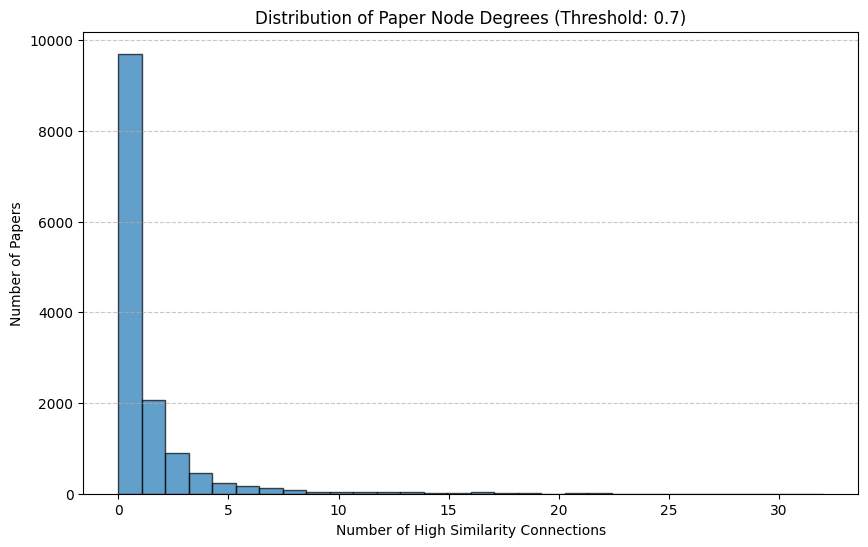

In [52]:
# Update 'high_similarity_count' column for the new threshold (0.7)
df['high_similarity_count'] = [
    sum(1 for sim in similarities if sim > 0.7 and sim != 1.0) for similarities in similarity_matrix
]

# Calculate and print the new average degree
average_degree = df['high_similarity_count'].mean()
print(f"The average degree of paper nodes with a 0.7 similarity threshold is: {average_degree:.2f}")

# Plot the updated distribution
plt.figure(figsize=(10, 6))
plt.hist(df['high_similarity_count'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paper Node Degrees (Threshold: 0.7)')
plt.xlabel('Number of High Similarity Connections')
plt.ylabel('Number of Papers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Detailed Distribution Analysis:
bin_range  paper_count  percentage  mean_connections  max_connections  min_connections
      0-3        11775   84.035113          0.958471              2.0              0.0
     3-10         1990   14.202112          4.293970              9.0              3.0
    10-20          218    1.555809         13.211009             19.0             10.0
    20-50           29    0.206965         23.724138             32.0             20.0
   50-100            0    0.000000               NaN              NaN              NaN
  100-inf            0    0.000000               NaN              NaN              NaN


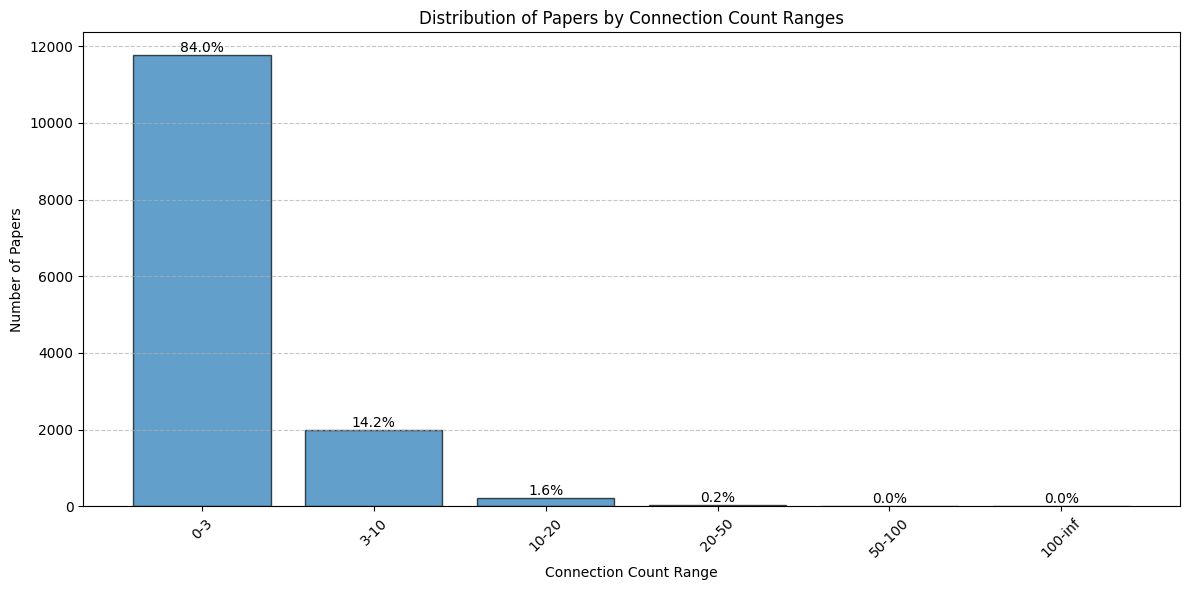

In [53]:
def analyze_paper_distribution(df, bin_ranges):
    """
    Analyze paper distribution across custom bins of connection counts.
    
    Parameters:
    df: DataFrame containing the 'high_similarity_count' column
    bin_ranges: List of tuples containing (start, end) for each bin
    
    Returns:
    DataFrame with bin statistics
    """
    # Initialize results storage
    results = []
    
    # Calculate statistics for each bin
    for start, end in bin_ranges:
        # Count papers in this range
        papers_in_range = df[
            (df['high_similarity_count'] >= start) & 
            (df['high_similarity_count'] < end)
        ]
        
        bin_stats = {
            'bin_range': f'{start}-{end}',
            'paper_count': len(papers_in_range),
            'percentage': (len(papers_in_range) / len(df)) * 100,
            'mean_connections': papers_in_range['high_similarity_count'].mean(),
            'max_connections': papers_in_range['high_similarity_count'].max(),
            'min_connections': papers_in_range['high_similarity_count'].min()
        }
        results.append(bin_stats)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def plot_binned_distribution(results_df):
    """
    Create a bar plot of the binned distribution with percentage labels.
    
    Parameters:
    results_df: DataFrame containing the bin analysis results
    """
    plt.figure(figsize=(12, 6))
    bars = plt.bar(results_df['bin_range'], results_df['paper_count'], 
                   edgecolor='black', alpha=0.7)
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        percentage = (height / results_df['paper_count'].sum()) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{percentage:.1f}%',
                ha='center', va='bottom')
    
    plt.title('Distribution of Papers by Connection Count Ranges')
    plt.xlabel('Connection Count Range')
    plt.ylabel('Number of Papers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt

# Define custom bin ranges
bin_ranges = [
    (0, 3),
    (3, 10),
    (10, 20),
    (20, 50),
    (50, 100),
    (100, float('inf'))
]

# Example usage:
results = analyze_paper_distribution(df, bin_ranges)
print("\nDetailed Distribution Analysis:")
print(results.to_string(index=False))
plot_binned_distribution(results)
plt.show()

/var/folders/4y/mcf4_fj97kx3sy4fvyk9kypw0000gn/T/ipykernel_53011/328676949.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


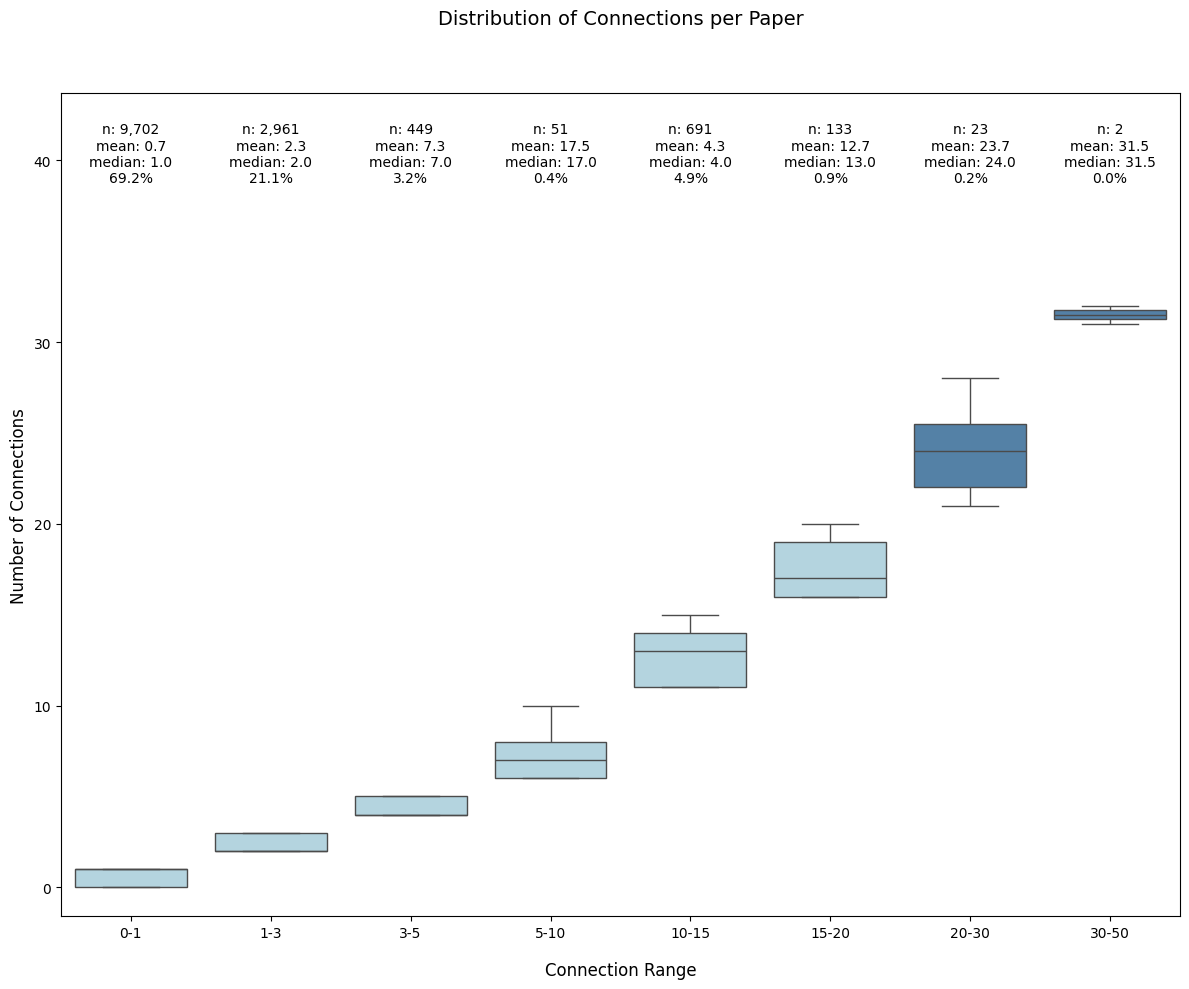

/var/folders/4y/mcf4_fj97kx3sy4fvyk9kypw0000gn/T/ipykernel_53011/328676949.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


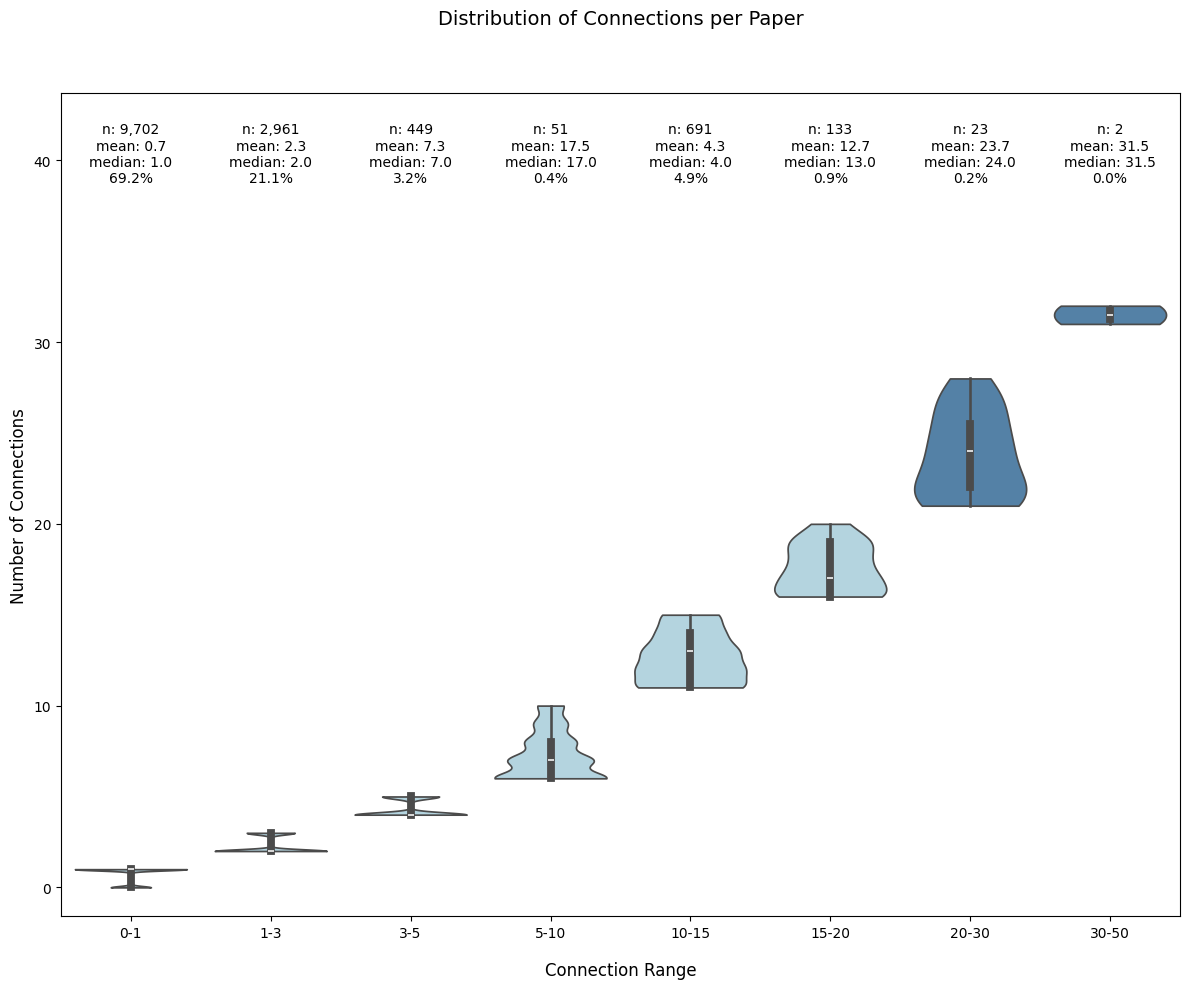

In [61]:
def create_box_plot_fixed_spacing(df, bin_ranges_detailed):
    """Create a box plot with proper spacing between labels and title"""
    # Create bin labels
    df['connection_range'] = pd.cut(
        df['high_similarity_count'],
        bins=[start for start, end, _ in bin_ranges_detailed] + [float('inf')],
        labels=[label for _, _, label in bin_ranges_detailed],
        include_lowest=True
    )
    
    # Create figure with more vertical space
    plt.figure(figsize=(12, 10))  # Increased height for better spacing
    
    # Create box plot
    ax = sns.boxplot(
        data=df,
        x='connection_range',
        y='high_similarity_count',
        palette=['lightblue'] * 6 + ['steelblue'] * 2
    )
    
    # Set title and labels
    ax.set_title('Distribution of Connections per Paper', pad=50, fontsize=14)  # Increased padding
    ax.set_xlabel('Connection Range', fontsize=12, labelpad=15)
    ax.set_ylabel('Number of Connections', fontsize=12)
    
    # Keep x-axis labels horizontal
    plt.xticks(rotation=0)
    
    # Add statistics annotations with adjusted vertical positioning
    stats_y_offset = 0.15  # Reduced offset to lower the stat boxes
    max_y = df['high_similarity_count'].max()
    
    # Get current axis limits
    y_min, y_max = ax.get_ylim()
    
    # Set new y limit to make room for labels
    ax.set_ylim(y_min, y_max * 1.3)  # Adjusted multiplier for better spacing
    
    for i, label in enumerate(df['connection_range'].unique()):
        stats = df[df['connection_range'] == label]['high_similarity_count']
        if len(stats) > 0:
            stats_text = (
                f"n: {len(stats):,}\n"
                f"mean: {stats.mean():.1f}\n"
                f"median: {stats.median():.1f}\n"
                f"{(len(stats)/len(df)*100):.1f}%"
            )
            
            # Position text with adjusted vertical spacing
            plt.text(i, y_max * (1 + stats_y_offset), stats_text,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Define bin ranges
bin_ranges_detailed = [
    (0, 1, '0-1'),
    (1, 3, '1-3'),
    (3, 5, '3-5'),
    (5, 10, '5-10'),
    (10, 15, '10-15'),
    (15, 20, '15-20'),
    (20, 30, '20-30'),
    (30, 50, '30-50')
]

# Example usage:
box_fig = create_box_plot_fixed_spacing(df, bin_ranges_detailed)
plt.show()

def create_violin_plot_fixed_spacing(df, bin_ranges_detailed):
    """Create a violin plot with proper spacing between labels and title"""
    # Create bin labels
    df['connection_range'] = pd.cut(
        df['high_similarity_count'],
        bins=[start for start, end, _ in bin_ranges_detailed] + [float('inf')],
        labels=[label for _, _, label in bin_ranges_detailed],
        include_lowest=True
    )
    
    # Create figure with more vertical space
    plt.figure(figsize=(12, 10))
    
    # Create violin plot
    ax = sns.violinplot(
        data=df,
        x='connection_range',
        y='high_similarity_count',
        palette=['lightblue'] * 6 + ['steelblue'] * 2,
        cut=0  # Don't extend beyond data range
    )
    
    # Set title and labels
    ax.set_title('Distribution of Connections per Paper', pad=50, fontsize=14)
    ax.set_xlabel('Connection Range', fontsize=12, labelpad=15)
    ax.set_ylabel('Number of Connections', fontsize=12)
    
    # Keep x-axis labels horizontal
    plt.xticks(rotation=0)
    
    # Add statistics annotations with adjusted vertical positioning
    stats_y_offset = 0.15
    max_y = df['high_similarity_count'].max()
    
    # Get current axis limits
    y_min, y_max = ax.get_ylim()
    
    # Set new y limit to make room for labels
    ax.set_ylim(y_min, y_max * 1.3)
    
    for i, label in enumerate(df['connection_range'].unique()):
        stats = df[df['connection_range'] == label]['high_similarity_count']
        if len(stats) > 0:
            stats_text = (
                f"n: {len(stats):,}\n"
                f"mean: {stats.mean():.1f}\n"
                f"median: {stats.median():.1f}\n"
                f"{(len(stats)/len(df)*100):.1f}%"
            )
            
            # Position text with adjusted vertical spacing
            plt.text(i, y_max * (1 + stats_y_offset), stats_text,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Define bin ranges (same as box plot)
bin_ranges_detailed = [
    (0, 1, '0-1'),
    (1, 3, '1-3'),
    (3, 5, '3-5'),
    (5, 10, '5-10'),
    (10, 15, '10-15'),
    (15, 20, '15-20'),
    (20, 30, '20-30'),
    (30, 50, '30-50')
]

# Example usage:
violin_fig = create_violin_plot_fixed_spacing(df, bin_ranges_detailed)
plt.show()

#### Analyzing 0.6 threhsold

Number of nodes with degree 0: 788
Number of nodes with degree 1: 2417
The average degree of paper nodes with a 0.7 similarity threshold is: 7.65


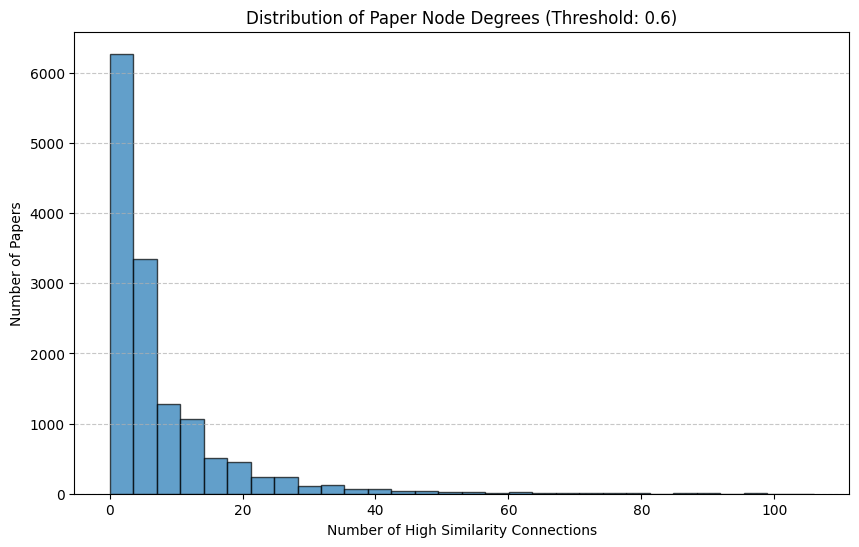

In [63]:
# Update 'high_similarity_count' column for the new threshold (0.6)
df['high_similarity_count'] = [
    sum(1 for sim in similarities if sim > 0.6 and sim != 1.0) for similarities in similarity_matrix
]

# Calculate the average degree for paper nodes with a threshold of 0.6
average_degree = df['high_similarity_count'].mean()
# Calculate and print the number of nodes with degree 0 and degree 1
num_zero_degree_nodes = (df['high_similarity_count'] == 0).sum()
num_one_degree_nodes = (df['high_similarity_count'] == 1).sum()
print(f"Number of nodes with degree 0: {num_zero_degree_nodes}")
print(f"Number of nodes with degree 1: {num_one_degree_nodes}")

# Print the result
print(f"The average degree of paper nodes with a 0.7 similarity threshold is: {average_degree:.2f}")

# Plot the updated distribution
plt.figure(figsize=(10, 6))
plt.hist(df['high_similarity_count'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paper Node Degrees (Threshold: 0.6)')
plt.xlabel('Number of High Similarity Connections')
plt.ylabel('Number of Papers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Detailed Distribution Analysis:
bin_range  paper_count  percentage  mean_connections  max_connections  min_connections
      0-3         4935   35.219812          1.190881                2                0
     3-10         5594   39.922923          5.228280                9                3
    10-20         2205   15.736512         13.512018               19               10
    20-50         1124    8.021696         28.641459               49               20
   50-100          151    1.077648         64.496689               97               50
  100-inf            3    0.021410        105.000000              106              104


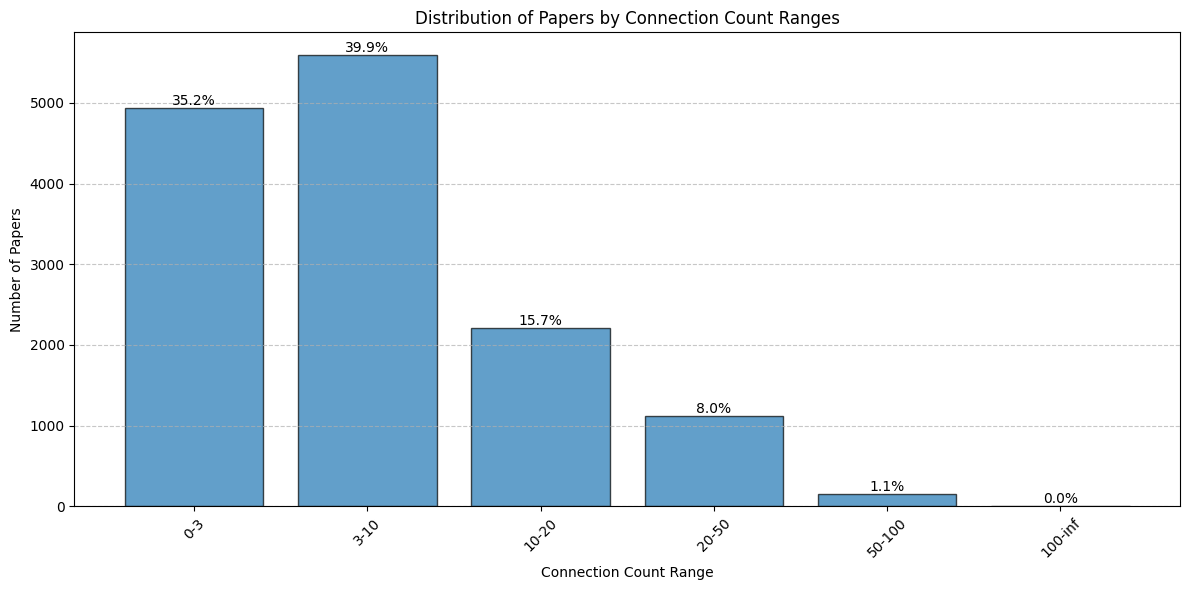

In [64]:
def analyze_paper_distribution(df, bin_ranges):
    """
    Analyze paper distribution across custom bins of connection counts.
    
    Parameters:
    df: DataFrame containing the 'high_similarity_count' column
    bin_ranges: List of tuples containing (start, end) for each bin
    
    Returns:
    DataFrame with bin statistics
    """
    # Initialize results storage
    results = []
    
    # Calculate statistics for each bin
    for start, end in bin_ranges:
        # Count papers in this range
        papers_in_range = df[
            (df['high_similarity_count'] >= start) & 
            (df['high_similarity_count'] < end)
        ]
        
        bin_stats = {
            'bin_range': f'{start}-{end}',
            'paper_count': len(papers_in_range),
            'percentage': (len(papers_in_range) / len(df)) * 100,
            'mean_connections': papers_in_range['high_similarity_count'].mean(),
            'max_connections': papers_in_range['high_similarity_count'].max(),
            'min_connections': papers_in_range['high_similarity_count'].min()
        }
        results.append(bin_stats)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def plot_binned_distribution(results_df):
    """
    Create a bar plot of the binned distribution with percentage labels.
    
    Parameters:
    results_df: DataFrame containing the bin analysis results
    """
    plt.figure(figsize=(12, 6))
    bars = plt.bar(results_df['bin_range'], results_df['paper_count'], 
                   edgecolor='black', alpha=0.7)
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        percentage = (height / results_df['paper_count'].sum()) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{percentage:.1f}%',
                ha='center', va='bottom')
    
    plt.title('Distribution of Papers by Connection Count Ranges')
    plt.xlabel('Connection Count Range')
    plt.ylabel('Number of Papers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt

# Define custom bin ranges
bin_ranges = [
    (0, 3),
    (3, 10),
    (10, 20),
    (20, 50),
    (50, 100),
    (100, float('inf'))
]

# Example usage:
results = analyze_paper_distribution(df, bin_ranges)
print("\nDetailed Distribution Analysis:")
print(results.to_string(index=False))
plot_binned_distribution(results)
plt.show()

/var/folders/4y/mcf4_fj97kx3sy4fvyk9kypw0000gn/T/ipykernel_53011/2617847960.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


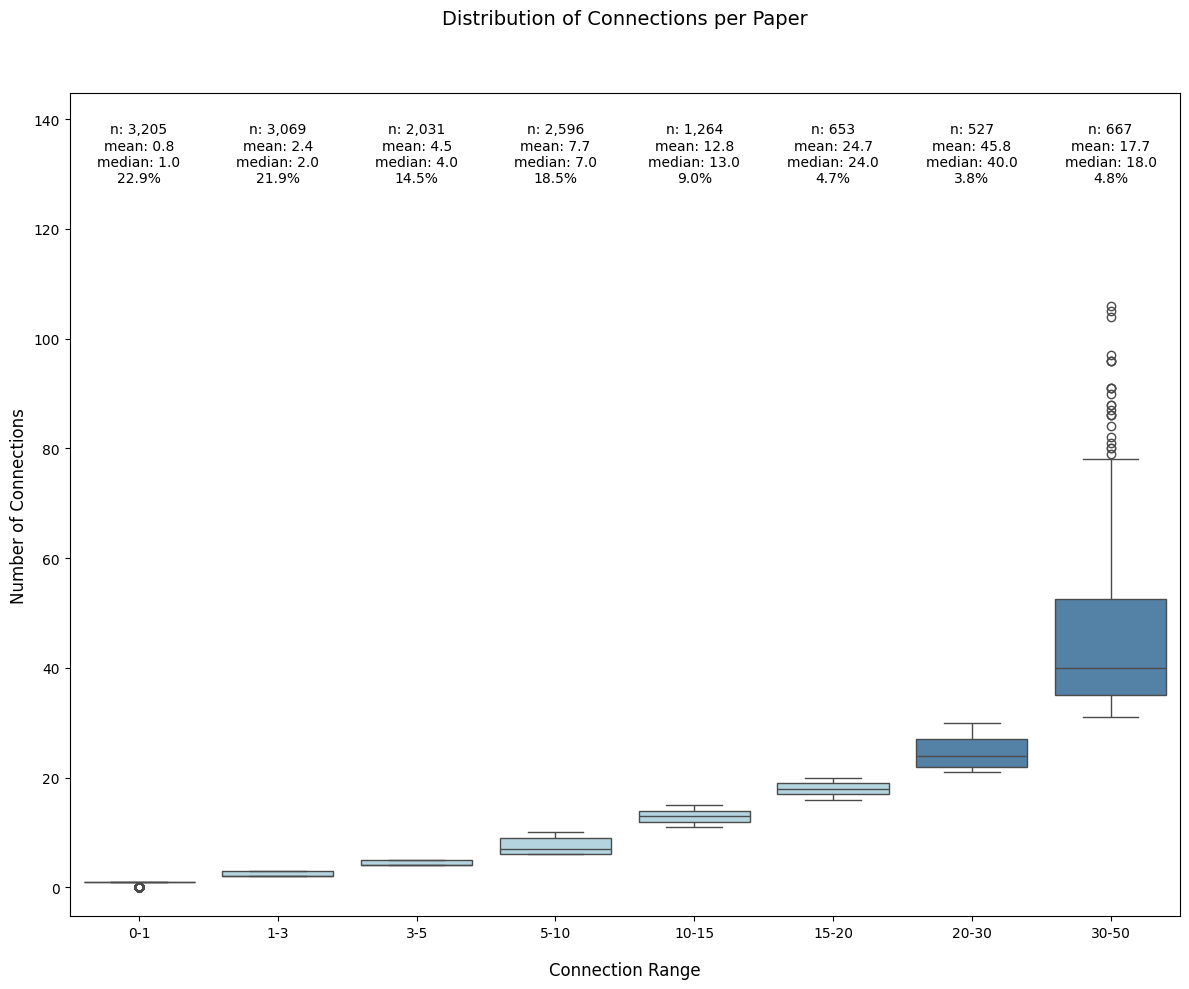

/var/folders/4y/mcf4_fj97kx3sy4fvyk9kypw0000gn/T/ipykernel_53011/2617847960.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


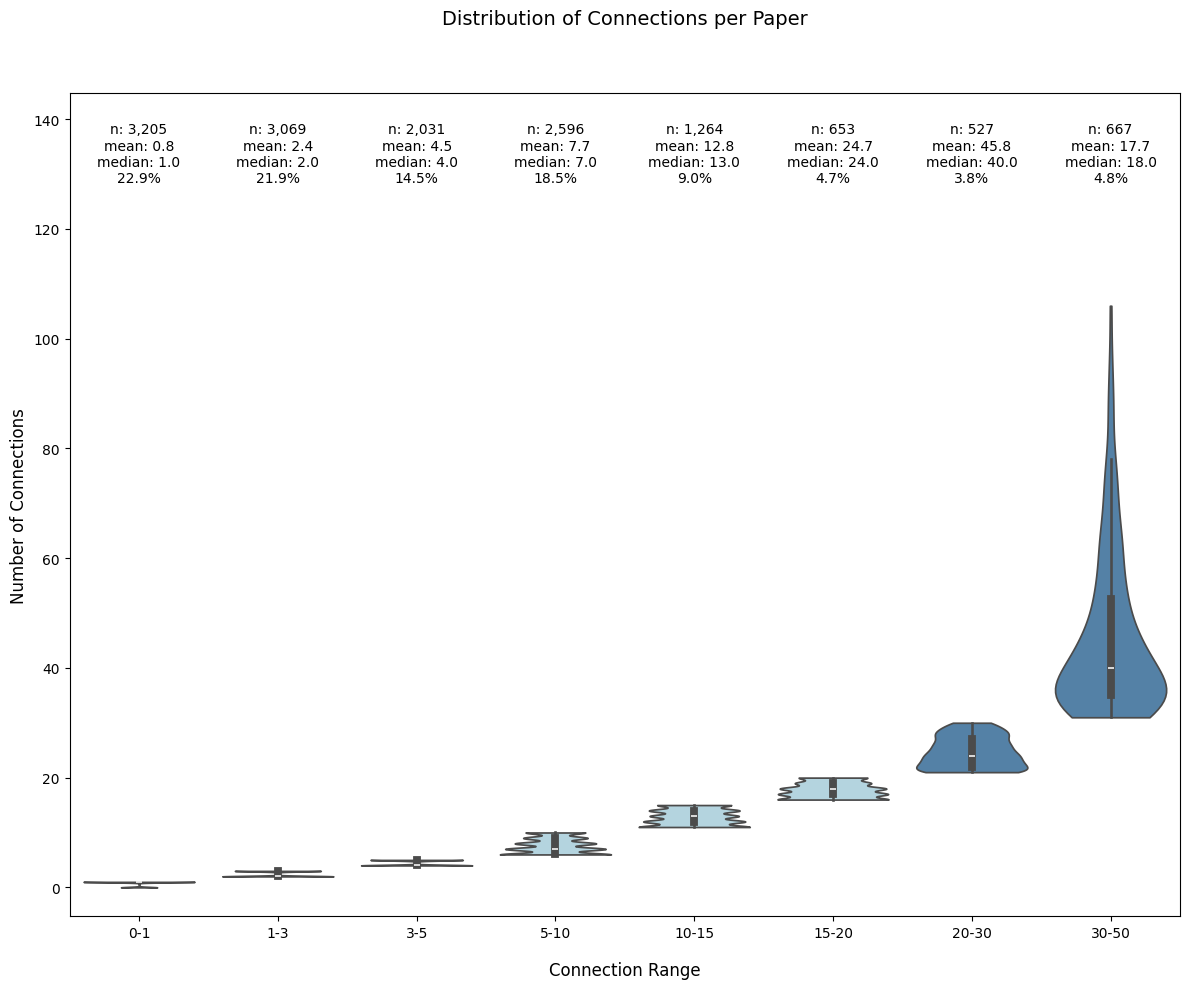

In [65]:
def create_box_plot_fixed_spacing(df, bin_ranges_detailed):
    """Create a box plot with proper spacing between labels and title"""
    # Create bin labels
    df['connection_range'] = pd.cut(
        df['high_similarity_count'],
        bins=[start for start, end, _ in bin_ranges_detailed] + [float('inf')],
        labels=[label for _, _, label in bin_ranges_detailed],
        include_lowest=True
    )
    
    # Create figure with more vertical space
    plt.figure(figsize=(12, 10))  # Increased height for better spacing
    
    # Create box plot
    ax = sns.boxplot(
        data=df,
        x='connection_range',
        y='high_similarity_count',
        palette=['lightblue'] * 6 + ['steelblue'] * 2
    )
    
    # Set title and labels
    ax.set_title('Distribution of Connections per Paper', pad=50, fontsize=14)  # Increased padding
    ax.set_xlabel('Connection Range', fontsize=12, labelpad=15)
    ax.set_ylabel('Number of Connections', fontsize=12)
    
    # Keep x-axis labels horizontal
    plt.xticks(rotation=0)
    
    # Add statistics annotations with adjusted vertical positioning
    stats_y_offset = 0.15  # Reduced offset to lower the stat boxes
    max_y = df['high_similarity_count'].max()
    
    # Get current axis limits
    y_min, y_max = ax.get_ylim()
    
    # Set new y limit to make room for labels
    ax.set_ylim(y_min, y_max * 1.3)  # Adjusted multiplier for better spacing
    
    for i, label in enumerate(df['connection_range'].unique()):
        stats = df[df['connection_range'] == label]['high_similarity_count']
        if len(stats) > 0:
            stats_text = (
                f"n: {len(stats):,}\n"
                f"mean: {stats.mean():.1f}\n"
                f"median: {stats.median():.1f}\n"
                f"{(len(stats)/len(df)*100):.1f}%"
            )
            
            # Position text with adjusted vertical spacing
            plt.text(i, y_max * (1 + stats_y_offset), stats_text,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Define bin ranges
bin_ranges_detailed = [
    (0, 1, '0-1'),
    (1, 3, '1-3'),
    (3, 5, '3-5'),
    (5, 10, '5-10'),
    (10, 15, '10-15'),
    (15, 20, '15-20'),
    (20, 30, '20-30'),
    (30, 50, '30-50')
]

# Example usage:
box_fig = create_box_plot_fixed_spacing(df, bin_ranges_detailed)
plt.show()

def create_violin_plot_fixed_spacing(df, bin_ranges_detailed):
    """Create a violin plot with proper spacing between labels and title"""
    # Create bin labels
    df['connection_range'] = pd.cut(
        df['high_similarity_count'],
        bins=[start for start, end, _ in bin_ranges_detailed] + [float('inf')],
        labels=[label for _, _, label in bin_ranges_detailed],
        include_lowest=True
    )
    
    # Create figure with more vertical space
    plt.figure(figsize=(12, 10))
    
    # Create violin plot
    ax = sns.violinplot(
        data=df,
        x='connection_range',
        y='high_similarity_count',
        palette=['lightblue'] * 6 + ['steelblue'] * 2,
        cut=0  # Don't extend beyond data range
    )
    
    # Set title and labels
    ax.set_title('Distribution of Connections per Paper', pad=50, fontsize=14)
    ax.set_xlabel('Connection Range', fontsize=12, labelpad=15)
    ax.set_ylabel('Number of Connections', fontsize=12)
    
    # Keep x-axis labels horizontal
    plt.xticks(rotation=0)
    
    # Add statistics annotations with adjusted vertical positioning
    stats_y_offset = 0.15
    max_y = df['high_similarity_count'].max()
    
    # Get current axis limits
    y_min, y_max = ax.get_ylim()
    
    # Set new y limit to make room for labels
    ax.set_ylim(y_min, y_max * 1.3)
    
    for i, label in enumerate(df['connection_range'].unique()):
        stats = df[df['connection_range'] == label]['high_similarity_count']
        if len(stats) > 0:
            stats_text = (
                f"n: {len(stats):,}\n"
                f"mean: {stats.mean():.1f}\n"
                f"median: {stats.median():.1f}\n"
                f"{(len(stats)/len(df)*100):.1f}%"
            )
            
            # Position text with adjusted vertical spacing
            plt.text(i, y_max * (1 + stats_y_offset), stats_text,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Define bin ranges (same as box plot)
bin_ranges_detailed = [
    (0, 1, '0-1'),
    (1, 3, '1-3'),
    (3, 5, '3-5'),
    (5, 10, '5-10'),
    (10, 15, '10-15'),
    (15, 20, '15-20'),
    (20, 30, '20-30'),
    (30, 50, '30-50')
]

# Example usage:
violin_fig = create_violin_plot_fixed_spacing(df, bin_ranges_detailed)
plt.show()

#### Analyzing 0.5 threshold

Number of nodes with degree 0: 69
Number of nodes with degree 1: 250
The average degree of paper nodes with a 0.7 similarity threshold is: 41.23


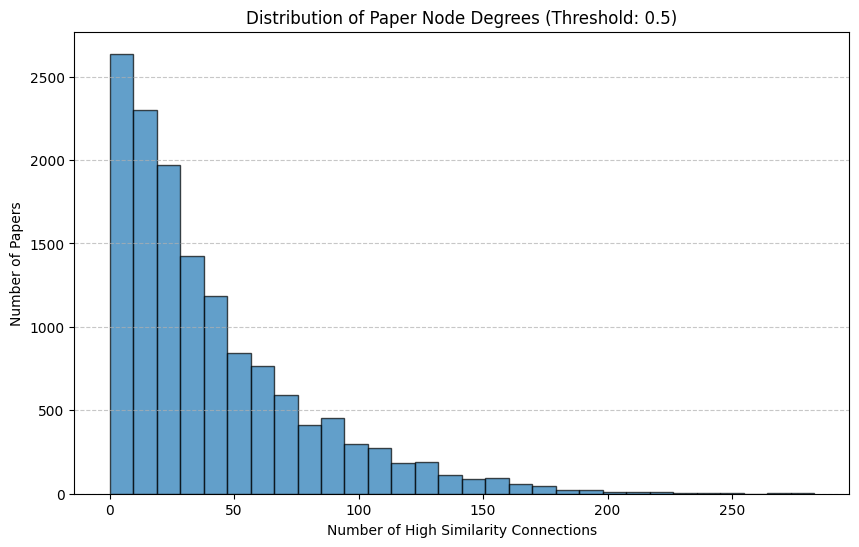

In [66]:
# Update 'high_similarity_count' column for the new threshold (0.5)
df['high_similarity_count'] = [
    sum(1 for sim in similarities if sim > 0.5 and sim != 1.0) for similarities in similarity_matrix
]

# Calculate the average degree for paper nodes with a threshold of 0.5
average_degree = df['high_similarity_count'].mean()
# Calculate and print the number of nodes with degree 0 and degree 1
num_zero_degree_nodes = (df['high_similarity_count'] == 0).sum()
num_one_degree_nodes = (df['high_similarity_count'] == 1).sum()
print(f"Number of nodes with degree 0: {num_zero_degree_nodes}")
print(f"Number of nodes with degree 1: {num_one_degree_nodes}")

# Print the result
print(f"The average degree of paper nodes with a 0.7 similarity threshold is: {average_degree:.2f}")

# Plot the updated distribution
plt.figure(figsize=(10, 6))
plt.hist(df['high_similarity_count'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paper Node Degrees (Threshold: 0.5)')
plt.xlabel('Number of High Similarity Connections')
plt.ylabel('Number of Papers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Detailed Distribution Analysis:
bin_range  paper_count  percentage  mean_connections  max_connections  min_connections
      0-3          623    4.446189          1.377207                2                0
     3-10         2014   14.373394          5.943893                9                3
    10-20         2519   17.977448         14.351727               19               10
    20-50         4563   32.564944         32.557747               49               20
   50-100         3029   21.617185         70.152526               99               50
  100-inf         1264    9.020839        132.649525              283              100


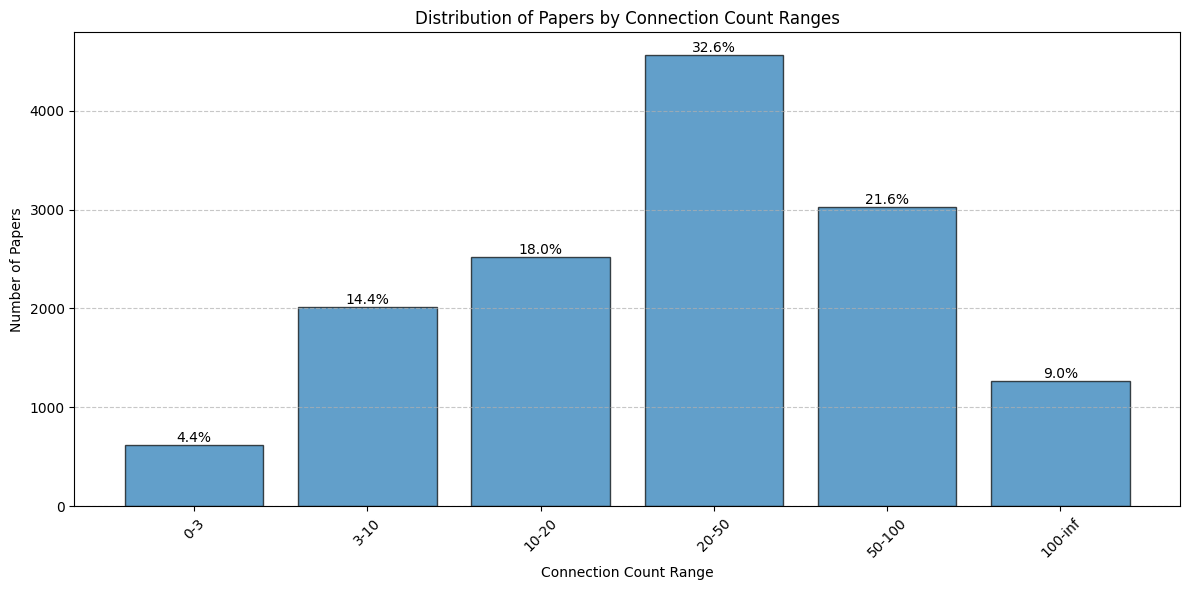

In [69]:
def analyze_paper_distribution(df, bin_ranges):
    """
    Analyze paper distribution across custom bins of connection counts.
    
    Parameters:
    df: DataFrame containing the 'high_similarity_count' column
    bin_ranges: List of tuples containing (start, end) for each bin
    
    Returns:
    DataFrame with bin statistics
    """
    # Initialize results storage
    results = []
    
    # Calculate statistics for each bin
    for start, end in bin_ranges:
        # Count papers in this range
        papers_in_range = df[
            (df['high_similarity_count'] >= start) & 
            (df['high_similarity_count'] < end)
        ]
        
        bin_stats = {
            'bin_range': f'{start}-{end}',
            'paper_count': len(papers_in_range),
            'percentage': (len(papers_in_range) / len(df)) * 100,
            'mean_connections': papers_in_range['high_similarity_count'].mean(),
            'max_connections': papers_in_range['high_similarity_count'].max(),
            'min_connections': papers_in_range['high_similarity_count'].min()
        }
        results.append(bin_stats)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def plot_binned_distribution(results_df):
    """
    Create a bar plot of the binned distribution with percentage labels.
    
    Parameters:
    results_df: DataFrame containing the bin analysis results
    """
    plt.figure(figsize=(12, 6))
    bars = plt.bar(results_df['bin_range'], results_df['paper_count'], 
                   edgecolor='black', alpha=0.7)
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        percentage = (height / results_df['paper_count'].sum()) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{percentage:.1f}%',
                ha='center', va='bottom')
    
    plt.title('Distribution of Papers by Connection Count Ranges')
    plt.xlabel('Connection Count Range')
    plt.ylabel('Number of Papers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt

# Define custom bin ranges
bin_ranges = [
    (0, 3),
    (3, 10),
    (10, 20),
    (20, 50),
    (50, 100),
    (100, float('inf'))
]

# Example usage:
results = analyze_paper_distribution(df, bin_ranges)
print("\nDetailed Distribution Analysis:")
print(results.to_string(index=False))
plot_binned_distribution(results)
plt.show()

/var/folders/4y/mcf4_fj97kx3sy4fvyk9kypw0000gn/T/ipykernel_53011/2617847960.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


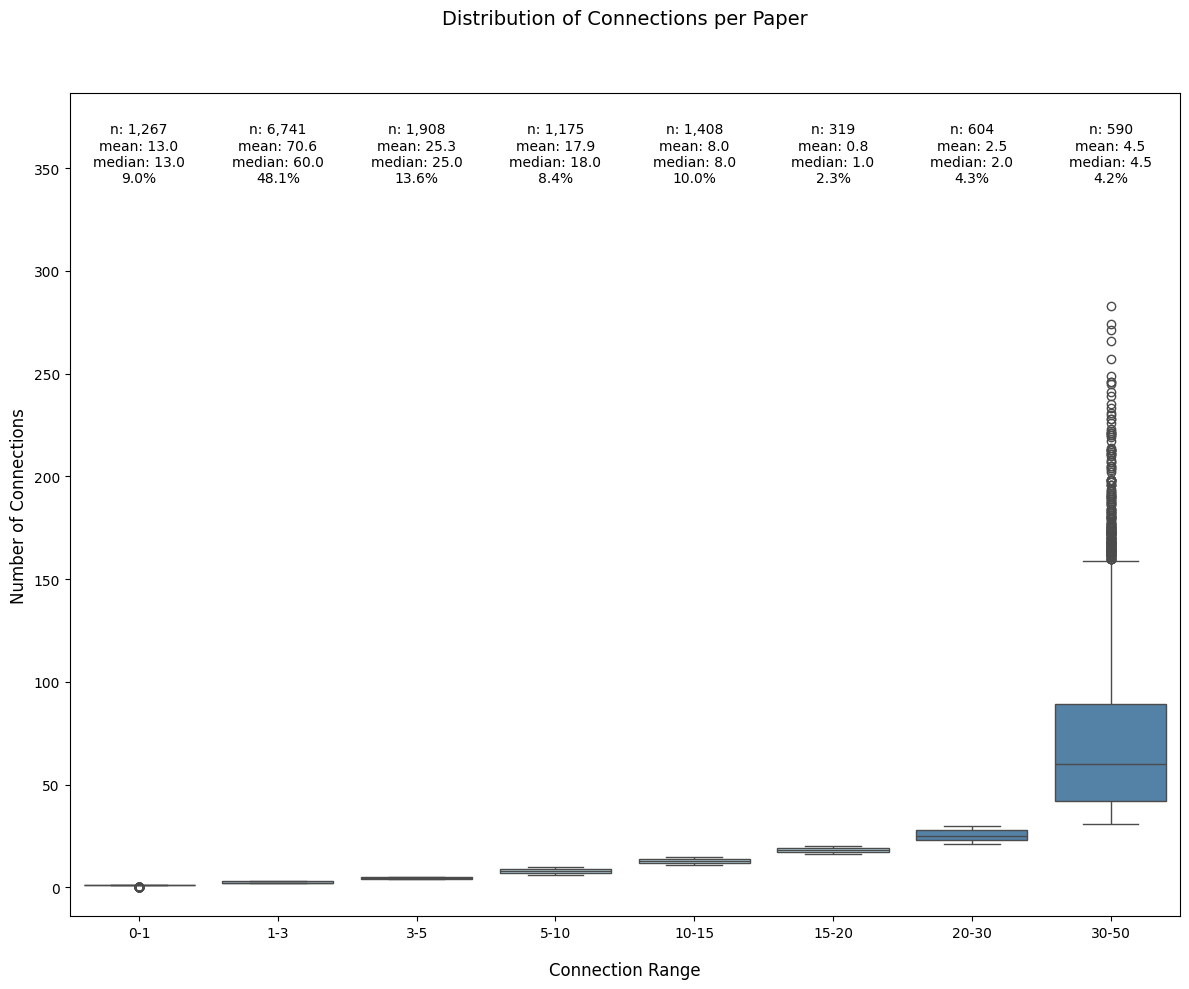

/var/folders/4y/mcf4_fj97kx3sy4fvyk9kypw0000gn/T/ipykernel_53011/2617847960.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


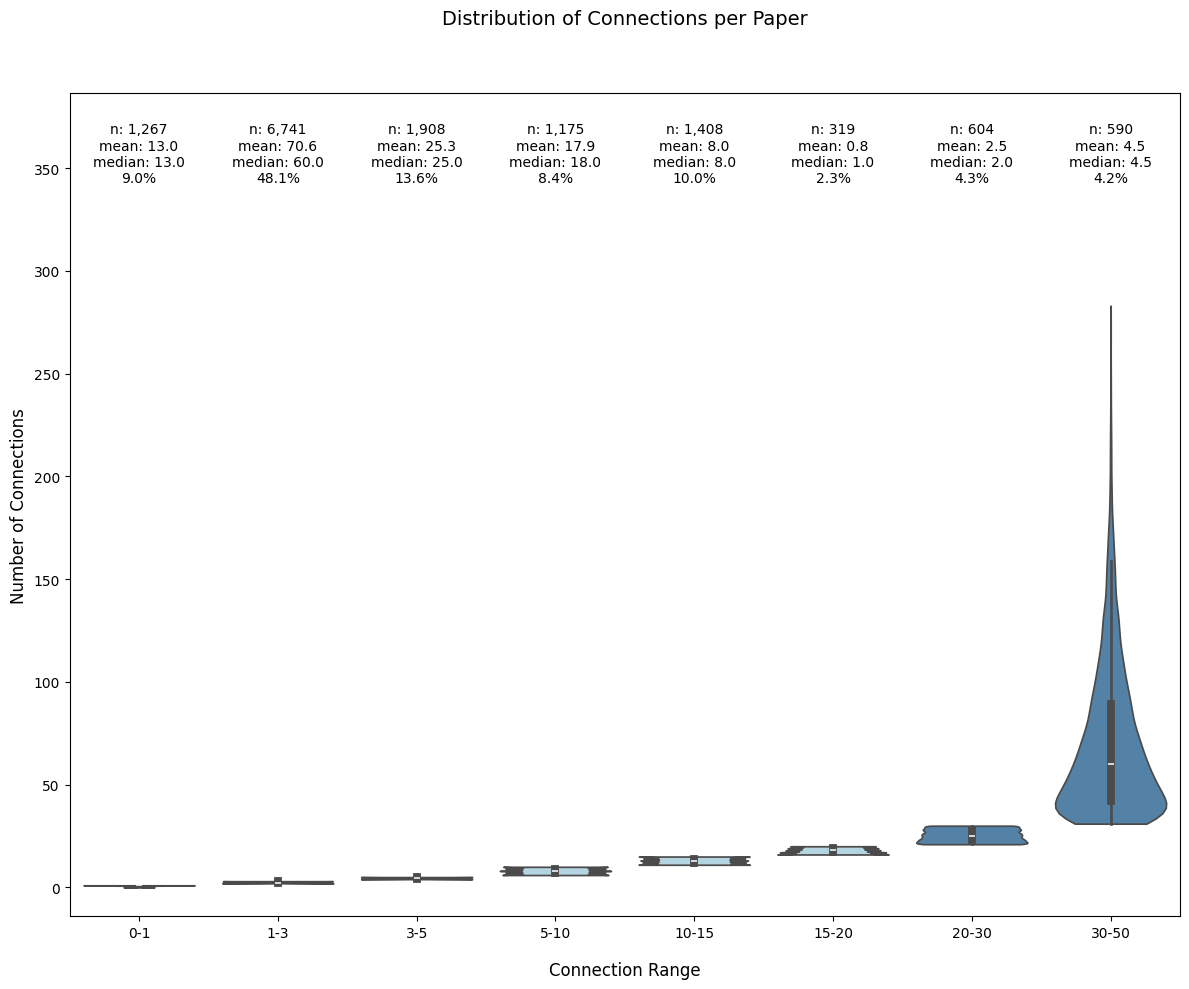

In [70]:
def create_box_plot_fixed_spacing(df, bin_ranges_detailed):
    """Create a box plot with proper spacing between labels and title"""
    # Create bin labels
    df['connection_range'] = pd.cut(
        df['high_similarity_count'],
        bins=[start for start, end, _ in bin_ranges_detailed] + [float('inf')],
        labels=[label for _, _, label in bin_ranges_detailed],
        include_lowest=True
    )
    
    # Create figure with more vertical space
    plt.figure(figsize=(12, 10))  # Increased height for better spacing
    
    # Create box plot
    ax = sns.boxplot(
        data=df,
        x='connection_range',
        y='high_similarity_count',
        palette=['lightblue'] * 6 + ['steelblue'] * 2
    )
    
    # Set title and labels
    ax.set_title('Distribution of Connections per Paper', pad=50, fontsize=14)  # Increased padding
    ax.set_xlabel('Connection Range', fontsize=12, labelpad=15)
    ax.set_ylabel('Number of Connections', fontsize=12)
    
    # Keep x-axis labels horizontal
    plt.xticks(rotation=0)
    
    # Add statistics annotations with adjusted vertical positioning
    stats_y_offset = 0.15  # Reduced offset to lower the stat boxes
    max_y = df['high_similarity_count'].max()
    
    # Get current axis limits
    y_min, y_max = ax.get_ylim()
    
    # Set new y limit to make room for labels
    ax.set_ylim(y_min, y_max * 1.3)  # Adjusted multiplier for better spacing
    
    for i, label in enumerate(df['connection_range'].unique()):
        stats = df[df['connection_range'] == label]['high_similarity_count']
        if len(stats) > 0:
            stats_text = (
                f"n: {len(stats):,}\n"
                f"mean: {stats.mean():.1f}\n"
                f"median: {stats.median():.1f}\n"
                f"{(len(stats)/len(df)*100):.1f}%"
            )
            
            # Position text with adjusted vertical spacing
            plt.text(i, y_max * (1 + stats_y_offset), stats_text,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Define bin ranges
bin_ranges_detailed = [
    (0, 1, '0-1'),
    (1, 3, '1-3'),
    (3, 5, '3-5'),
    (5, 10, '5-10'),
    (10, 15, '10-15'),
    (15, 20, '15-20'),
    (20, 30, '20-30'),
    (30, 50, '30-50')
]

# Example usage:
box_fig = create_box_plot_fixed_spacing(df, bin_ranges_detailed)
plt.show()

def create_violin_plot_fixed_spacing(df, bin_ranges_detailed):
    """Create a violin plot with proper spacing between labels and title"""
    # Create bin labels
    df['connection_range'] = pd.cut(
        df['high_similarity_count'],
        bins=[start for start, end, _ in bin_ranges_detailed] + [float('inf')],
        labels=[label for _, _, label in bin_ranges_detailed],
        include_lowest=True
    )
    
    # Create figure with more vertical space
    plt.figure(figsize=(12, 10))
    
    # Create violin plot
    ax = sns.violinplot(
        data=df,
        x='connection_range',
        y='high_similarity_count',
        palette=['lightblue'] * 6 + ['steelblue'] * 2,
        cut=0  # Don't extend beyond data range
    )
    
    # Set title and labels
    ax.set_title('Distribution of Connections per Paper', pad=50, fontsize=14)
    ax.set_xlabel('Connection Range', fontsize=12, labelpad=15)
    ax.set_ylabel('Number of Connections', fontsize=12)
    
    # Keep x-axis labels horizontal
    plt.xticks(rotation=0)
    
    # Add statistics annotations with adjusted vertical positioning
    stats_y_offset = 0.15
    max_y = df['high_similarity_count'].max()
    
    # Get current axis limits
    y_min, y_max = ax.get_ylim()
    
    # Set new y limit to make room for labels
    ax.set_ylim(y_min, y_max * 1.3)
    
    for i, label in enumerate(df['connection_range'].unique()):
        stats = df[df['connection_range'] == label]['high_similarity_count']
        if len(stats) > 0:
            stats_text = (
                f"n: {len(stats):,}\n"
                f"mean: {stats.mean():.1f}\n"
                f"median: {stats.median():.1f}\n"
                f"{(len(stats)/len(df)*100):.1f}%"
            )
            
            # Position text with adjusted vertical spacing
            plt.text(i, y_max * (1 + stats_y_offset), stats_text,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Define bin ranges (same as box plot)
bin_ranges_detailed = [
    (0, 1, '0-1'),
    (1, 3, '1-3'),
    (3, 5, '3-5'),
    (5, 10, '5-10'),
    (10, 15, '10-15'),
    (15, 20, '15-20'),
    (20, 30, '20-30'),
    (30, 50, '30-50')
]

# Example usage:
violin_fig = create_violin_plot_fixed_spacing(df, bin_ranges_detailed)
plt.show()

In [68]:
# Save DataFrame as a CSV file with 0.5 similarity threshold
df.to_csv('updated_dataframe.csv', index=False)


### Keyword and Jacard Similarity

The average degree of paper nodes with a keyword similarity threshold of 2 is: 270.61


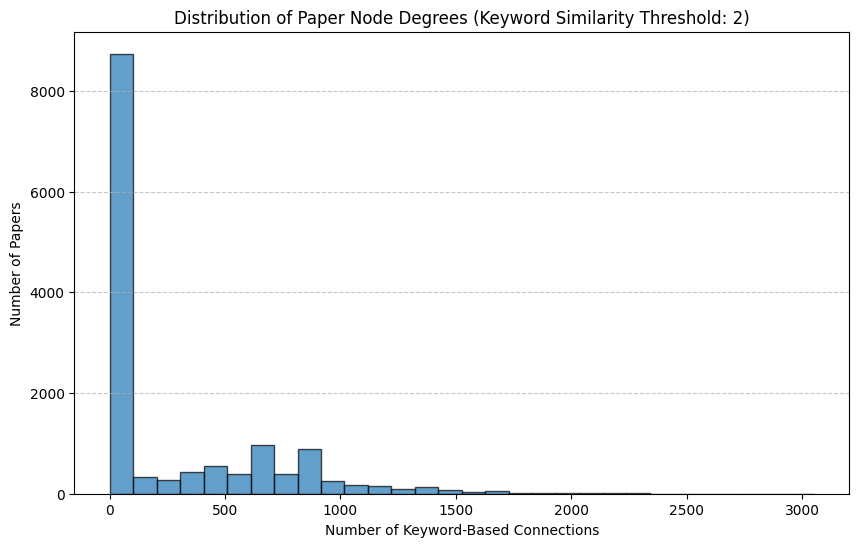

In [45]:
# Function to calculate keyword similarity
def count_similar_keywords(target_keywords, keywords_list, threshold=2):
    if pd.isna(target_keywords):
        return 0
    target_set = set(target_keywords.split(", "))
    count = 0
    for keywords in keywords_list:
        if pd.notna(keywords):
            common_keywords = target_set.intersection(set(keywords.split(", ")))
            if len(common_keywords) >= threshold:
                count += 1
    return count

# Apply the function across the DataFrame to count similar papers based on keywords
df['keyword_similarity_count'] = df['keywords'].apply(
    lambda x: count_similar_keywords(x, df['keywords'].tolist(), threshold=2)
)

# Calculate and print the average degree based on keyword similarity
average_degree_keyword_similarity = df['keyword_similarity_count'].mean()
print(f"The average degree of paper nodes with a keyword similarity threshold of 2 is: {average_degree_keyword_similarity:.2f}")

# Plot the distribution of the number of keyword-based connections
plt.figure(figsize=(10, 6))
plt.hist(df['keyword_similarity_count'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paper Node Degrees (Keyword Similarity Threshold: 2)')
plt.xlabel('Number of Keyword-Based Connections')
plt.ylabel('Number of Papers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The average degree of paper nodes with a Jaccard similarity threshold of 25% is: 179.73


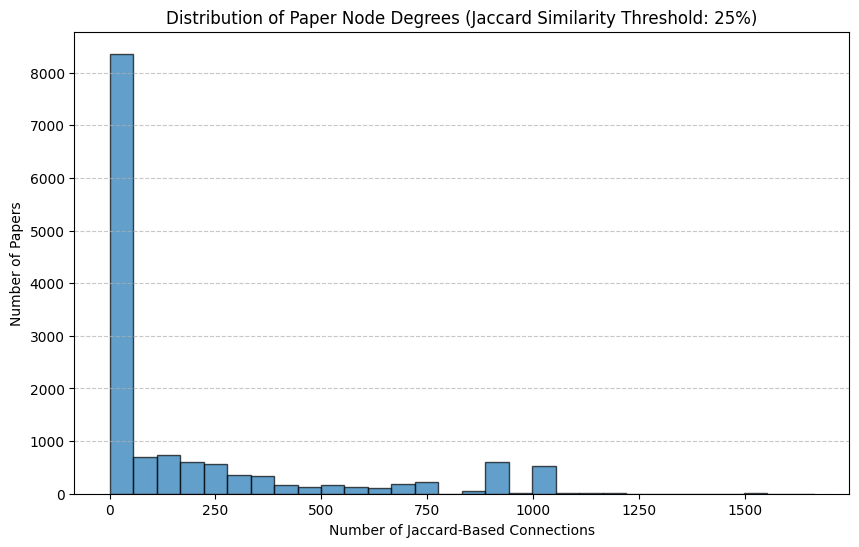

In [46]:
# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Function to count papers with Jaccard similarity >= 0.25
def count_jaccard_similar_papers(target_keywords, keywords_list, threshold=0.25):
    if pd.isna(target_keywords):
        return 0
    target_set = set(target_keywords.split(", "))
    count = 0
    for keywords in keywords_list:
        if pd.notna(keywords):
            keywords_set = set(keywords.split(", "))
            similarity = jaccard_similarity(target_set, keywords_set)
            if similarity >= threshold:
                count += 1
    return count

# Apply the function to count similar papers based on Jaccard similarity
df['jaccard_similarity_count'] = df['keywords'].apply(
    lambda x: count_jaccard_similar_papers(x, df['keywords'].tolist(), threshold=0.25)
)

# Calculate and print the average degree based on Jaccard similarity
average_degree_jaccard_similarity = df['jaccard_similarity_count'].mean()
print(f"The average degree of paper nodes with a Jaccard similarity threshold of 25% is: {average_degree_jaccard_similarity:.2f}")

# Plot the distribution of the number of Jaccard-based connections
plt.figure(figsize=(10, 6))
plt.hist(df['jaccard_similarity_count'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paper Node Degrees (Jaccard Similarity Threshold: 25%)')
plt.xlabel('Number of Jaccard-Based Connections')
plt.ylabel('Number of Papers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Ignore Keywords Extraction

In [26]:


doc = nlp("I watched the Pirates of the Caribbean last silvester")

# returns all entities in the whole document
all_linked_entities = doc._.linkedEntities
# iterates over sentences and prints linked entities
for sent in doc.sents:
    sent._.linkedEntities.pretty_print()

# OUTPUT:
# https://www.wikidata.org/wiki/Q194318     Pirates of the Caribbean        Series of fantasy adventure films                                                                   
# https://www.wikidata.org/wiki/Q12525597   Silvester                       the day celebrated on 31 December (Roman Catholic Church) or 2 January (Eastern Orthodox Churches)  

# entities are also directly accessible through spans
# doc[3:7]._.linkedEntities.pretty_print()
# OUTPUT:
# https://www.wikidata.org/wiki/Q194318     Pirates of the Caribbean        Series of fantasy adventure films

<EntityElement: https://www.wikidata.org/wiki/Q194318 Pirates of the Caribbean  Series of fantasy adventure films                 >
<EntityElement: https://www.wikidata.org/wiki/Q664609 Caribbean                 region to the center-east of America composed of many islands / coastal regions surrounding the Cari>
<EntityElement: https://www.wikidata.org/wiki/Q12525597 Silvester                 the day celebrated on 31 December (Roman Catholic Church) or 2 January (Eastern Orthodox Churches)>


In [ ]:
# entities are also directly accessible through spans
doc[3:7]._.linkedEntities.pretty_print()
# OUTPUT:
# https://www.wikidata.org/wiki/Q194318     Pirates of the Caribbean        Series of fantasy adventure films

In [27]:
df['abstract'][0]

"Despite many years of research and significant commercial investment, the malware problem is far from being solved (or even reasonably well contained). Every week, the mainstream press publishes articles that describe yet another incident where millions of credit cards were leaked, a large company discloses that adversaries had remote access to its corporate secrets for years, and we discover a new botnet with tens of thousands of compromised machines. Clearly, this situation is not acceptable, but why isn't it getting any better? In this talk, I will discuss some of the reasons why the malware problem is fundamentally hard, and why existing defenses in industry are no longer working. I will then outline progress that researchers and industry have made over the last years, and highlight a few milestones in our struggle to keep malicious code off our computer systems. This part will not focus on advances related to the analysis of malicious code alone, but take a broader perspective. H

In [41]:
doc = nlp(df['keywords'][4])

# returns all entities in the whole document
all_linked_entities = doc._.linkedEntities
# iterates over sentences and prints linked entities
for sent in doc.sents:
    sent._.linkedEntities.pretty_print()


doc = nlp(df['keywords'][4])
doc._.linkedEntities.print_super_entities()
# OUTPUT:
# human (3) : Elon Musk,Bill Gates,Steve Jobs
# country (2) : South Africa,United States of America
# sovereign state (2) : South Africa,United States of America
# federal state (1) : United States of America
# constitutional republic (1) : United States of America
# democratic republic (1) : United States of America


<EntityElement: https://www.wikidata.org/wiki/Q134130 Peter Gabriel             1982 studio album by Peter Gabriel                >
<EntityElement: https://www.wikidata.org/wiki/Q188728 privacy                   the ability of an individual or group to seclude themselves, or information about themselves>
<EntityElement: https://www.wikidata.org/wiki/Q989632 network security          computer network access control                   >
studio album (1) : Peter Gabriel
law (1) : privacy
rights (1) : privacy
computer security (1) : network security


In [43]:
doc = nlp(df['abstract'][2])

# returns all entities in the whole document
all_linked_entities = doc._.linkedEntities
# iterates over sentences and prints linked entities
for sent in doc.sents:
    sent._.linkedEntities.pretty_print()


doc = nlp(df['abstract'][2])
doc._.linkedEntities.print_super_entities()
# OUTPUT:
# human (3) : Elon Musk,Bill Gates,Steve Jobs
# country (2) : South Africa,United States of America
# sovereign state (2) : South Africa,United States of America
# federal state (1) : United States of America
# constitutional republic (1) : United States of America
# democratic republic (1) : United States of America


<EntityElement: https://www.wikidata.org/wiki/Q11472 paper                     thin, flexible material mainly used for writing upon, printing upon, drawing or for packaging>
<EntityElement: https://www.wikidata.org/wiki/Q8777 Hypertext Transfer Protocol application protocol for distributed, collaborative, hypermedia information systems>
<EntityElement: https://www.wikidata.org/wiki/Q35120 entity                    something that exists in the identified universe  >
<EntityElement: https://www.wikidata.org/wiki/Q35127 website                   set of related web pages served from a single web domain>
<EntityElement: https://www.wikidata.org/wiki/Q3884230 Opportunities             1985 single by Pet Shop Boys                      >
<EntityElement: https://www.wikidata.org/wiki/Q29142 attempt                   occurs if a criminal has an intent to commit a crime and takes a substantial step toward completing >
<EntityElement: https://www.wikidata.org/wiki/Q42213 work                      

In [32]:
doc = nlp(df['keywords'][0])
sents = list(doc.sents)
ent = doc._.linkedEntities[0]

# using the SpanInfo class
span = ent.get_span()
print(span.start, span.end, span.text) # behaves like a Span

# check equivalence
print(span == doc[0:1]) # True
print(doc[0:1] == span) # TypeError: Argument 'other' has incorrect type (expected spacy.tokens.span.Span, got SpanInfo)

# now get the real span
span = ent.get_span(doc) # passing the doc instance here
print(span.start, span.end, span.text)

print(span == doc[0:1]) # True
print(doc[0:1] == span) # True

0 1 Security
True
True
0 1 Security
True
True


In [36]:

doc = nlp("I follow the New England Patriots")

patriots_entity = doc._.linkedEntities[0]
patriots_entity.pretty_print()
# OUTPUT:
# https://www.wikidata.org/wiki/Q193390     
# New England Patriots            
# National Football League franchise in Foxborough, Massachusetts                    

football_team_entity = patriots_entity.get_super_entities()[0]
football_team_entity.pretty_print()
# OUTPUT:
# https://www.wikidata.org/wiki/Q17156793 
# American football team          
# organization, in which a group of players are organized to compete as a team in American football   


for child in football_team_entity.get_sub_entities(limit=32):
    print(child)
    # OUTPUT:
    # New Orleans Saints
    # New York Giants
    # Pittsburgh Steelers
    # New England Patriots
    # Indianapolis Colts
    # Miami Seahawks
    # Dallas Cowboys
    # Chicago Bears
    # Washington Redskins
    # Green Bay Packers
    # ...

<EntityElement: https://www.wikidata.org/wiki/Q193390 New England Patriots      National Football League franchise in Foxborough, Massachusetts>
<EntityElement: https://www.wikidata.org/wiki/Q17156793 American football team    organization, in which a group of players are organized to compete as a team in American football>
New Orleans Saints
New York Giants
Pittsburgh Steelers
New England Patriots
Indianapolis Colts
Miami Seahawks
Dallas Cowboys
Chicago Bears
Washington Redskins
Green Bay Packers
New York Jets
Philadelphia Eagles
Minnesota Vikings
Buffalo Bills
Seattle Seahawks
Miami Dolphins
Denver Broncos
Cincinnati Bengals
Houston Texans
Kansas City Chiefs
Cleveland Browns
Arizona Cardinals
Zurich Renegades
Detroit Lions
Atlanta Falcons
Los Angeles Chargers
Jacksonville Jaguars
Baltimore Ravens
Red Barons Cologne
Düsseldorf Panther
Schwäbisch Hall Unicorns
Marburg Mercenaries
